## Credit Card Fraud Detection
This dataset contains information about credit card transactions, and the task is to see if you can build a model that detects fraudulent transactions. The dataset is heavily imbalanced towards examples of non-fraudulent transactions, thus it's better to look at subsamples of the dataset with an equal distribution of class labels. Also, most of the features in the dataset have already been transformed with PCA because of confidentiality reasons with the original data. 

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(randomForest))
suppressMessages(library(ggplot2))
suppressMessages(library(modelr))
suppressMessages(library(lightgbm))
suppressMessages(library(xgboost))
suppressMessages(library(pROC))

options(repr.plot.width=5, repr.plot.height=5)

### Importing Dataset

In [2]:
set.seed(42)

df = read_csv("creditcard.csv", col_types=cols())
head(df)

Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,⋯,-0.018306778,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0
0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,⋯,-0.225775248,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0
1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,⋯,0.247998153,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0
1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,⋯,-0.108300452,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0
2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,⋯,-0.009430697,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0
2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,⋯,-0.208253515,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0


In [3]:
summary(df)

      Time              V1                  V2                  V3          
 Min.   :     0   Min.   :-56.40751   Min.   :-72.71573   Min.   :-48.3256  
 1st Qu.: 54202   1st Qu.: -0.92037   1st Qu.: -0.59855   1st Qu.: -0.8904  
 Median : 84692   Median :  0.01811   Median :  0.06549   Median :  0.1799  
 Mean   : 94814   Mean   :  0.00000   Mean   :  0.00000   Mean   :  0.0000  
 3rd Qu.:139320   3rd Qu.:  1.31564   3rd Qu.:  0.80372   3rd Qu.:  1.0272  
 Max.   :172792   Max.   :  2.45493   Max.   : 22.05773   Max.   :  9.3826  
       V4                 V5                   V6                 V7          
 Min.   :-5.68317   Min.   :-113.74331   Min.   :-26.1605   Min.   :-43.5572  
 1st Qu.:-0.84864   1st Qu.:  -0.69160   1st Qu.: -0.7683   1st Qu.: -0.5541  
 Median :-0.01985   Median :  -0.05434   Median : -0.2742   Median :  0.0401  
 Mean   : 0.00000   Mean   :   0.00000   Mean   :  0.0000   Mean   :  0.0000  
 3rd Qu.: 0.74334   3rd Qu.:   0.61193   3rd Qu.:  0.3986   3rd Qu

### Looking at the Imbalance of Dataset Labels


     0      1 
284315    492 

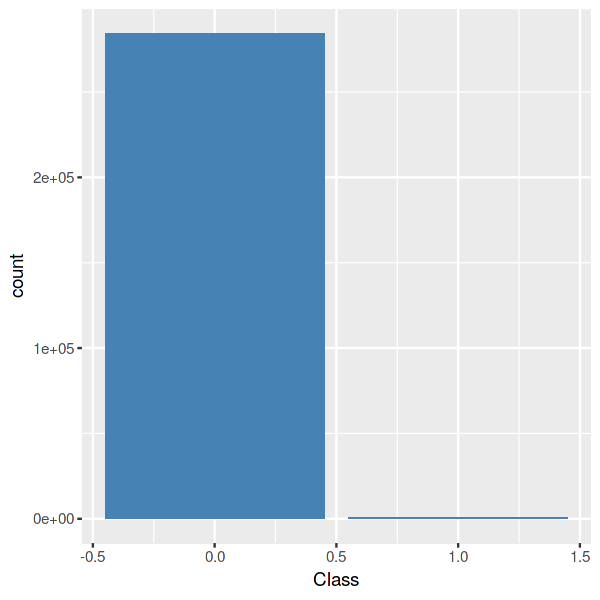

In [4]:
table(df$Class)
ggplot(df, aes(Class)) + geom_bar(fill="steelblue")

### Creating Balanced Subsample from Dataset

In [5]:
frauds <- filter(df, Class == 1)
not_frauds <- filter(df, Class == 0)
print(paste("Frauds size:",dim(frauds)[1]))
print(paste("Non-Frauds size:",dim(not_frauds)[1]))

[1] "Frauds size: 492"
[1] "Non-Frauds size: 284315"


In [6]:
not_frauds_sample <- sample(1:nrow(not_frauds), nrow(frauds))
not_frauds_subsample <- not_frauds[not_frauds_sample, ]
print(paste("Non-Frauds subsample size:",dim(not_frauds_subsample)[1]))

[1] "Non-Frauds subsample size: 492"


In [7]:
df_subsample <- rbind(frauds, not_frauds_subsample)
shuffle <- sample(nrow(df_subsample))
df_subsample <- df_subsample[shuffle, ]
print(paste("New combined subsample size:",dim(df_subsample)[1]))

[1] "New combined subsample size: 984"


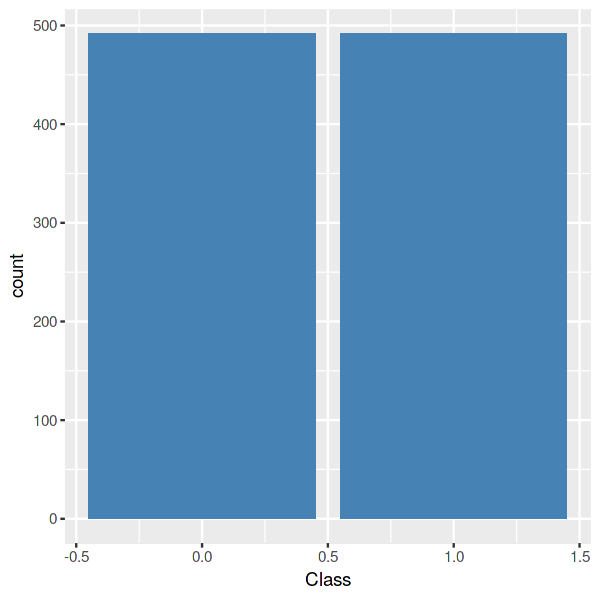

In [8]:
ggplot(df_subsample, aes(Class)) + geom_bar(fill="steelblue")

### Splitting Dataset into Training/Test set

In [9]:
df_subsample$Class <- as.factor(df_subsample$Class)
train_rows <- sample(1:nrow(df_subsample), 0.75*nrow(df_subsample))
train_df <- df_subsample[train_rows,]
test_df <- df_subsample[-train_rows,]
print(paste("Training set size:",dim(train_df)[1]))
print(paste("Test set size:",dim(test_df)[1]))

[1] "Training set size: 738"
[1] "Test set size: 246"


### Scaling the Data

In [10]:
time_mean <- mean(train_df$Time)
time_sd <- sd(train_df$Time)
amount_mean <- mean(train_df$Amount)
amount_sd <- sd(train_df$Amount)

train_df$Time <- (train_df$Time - time_mean) / time_sd
test_df$Time <- (test_df$Time - time_mean) / time_sd
train_df$Amount <- (train_df$Amount - amount_mean) / amount_sd
test_df$Amount <- (test_df$Amount - amount_mean) / amount_sd

In [11]:
plot_confusion_matrix <- function(table) {
    
    Prediction <- factor(c(0, 0, 1, 1))
    Actual <- factor(c(0, 1, 0, 1))
    table_vals <- as.numeric(table)
    df <- data.frame(Actual, Prediction, table_vals)

    ggplot(data=df, aes(x=Actual, y=Prediction)) +
      geom_tile(aes(fill=table_vals), colour="white") +
      geom_text(aes(label=sprintf("%1.0f", table_vals))) +
      scale_fill_gradient(low="lightgreen", high="darkgreen") +
      theme_bw() +
      theme(legend.position="none", 
            axis.text=element_text(size=18), 
            axis.title=element_text(size=14))
}

### Logistic Regression Model

In [12]:
lr_model <- glm(Class~., data=train_df, family=binomial, maxit=100)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


[1] "Linear Regression test accuracy: 92.68 %"


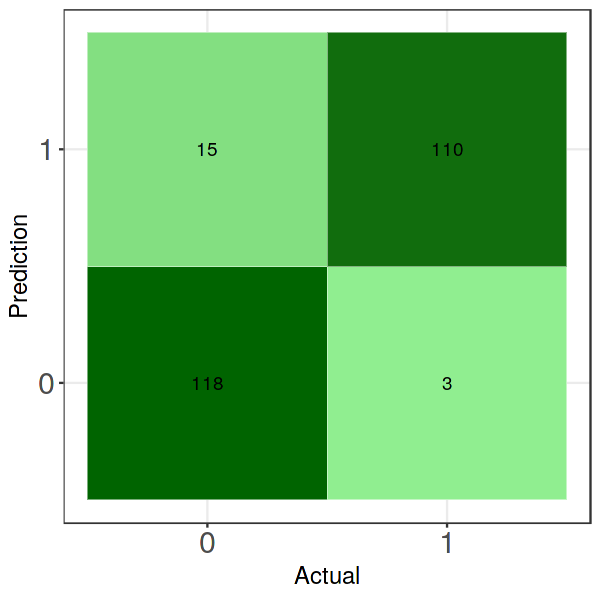

In [13]:
probs <- predict(lr_model, test_df)
preds <- as.numeric(probs > 0.5)
plot_confusion_matrix(table(preds, test_df$Class))

acc <- round(mean(preds == test_df$Class), 4) * 100
print(paste("Linear Regression test accuracy:", acc, "%"))

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train_df$Class, predictor = probs, plot = TRUE,     print.auc = TRUE, auc.polygon = TRUE)

Data: probs in 371 controls (train_df$Class 0) < 367 cases (train_df$Class 1).
Area under the curve: 0.9939

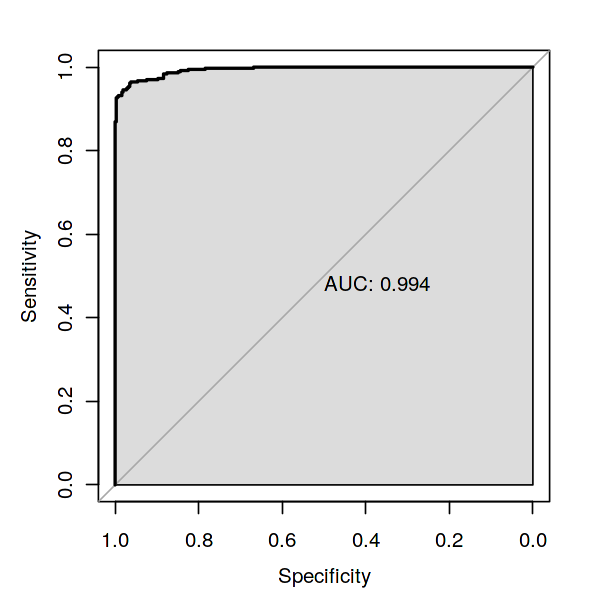

In [14]:
probs <- predict(lr_model, train_df)
roc(train_df$Class, probs, plot=TRUE, print.auc=TRUE, auc.polygon=TRUE)

### Random Forest Model

In [15]:
rf_model <- randomForest(Class~., data=train_df, ntree=500, mtry=2)

[1] "Random Forest test accuracy: 91.06 %"


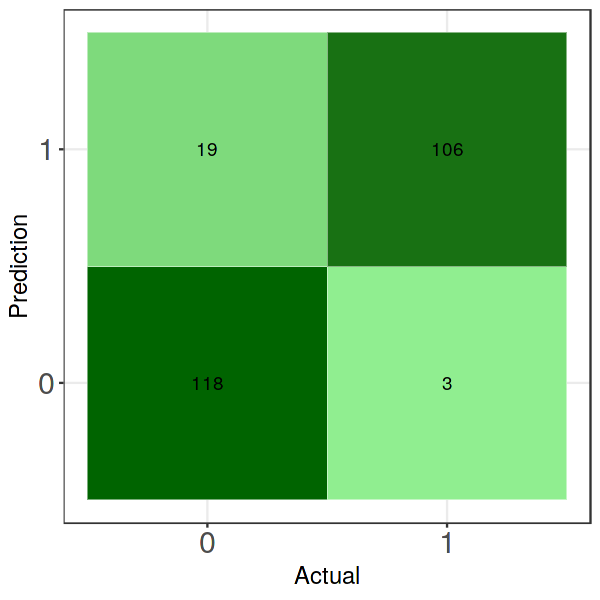

In [16]:
preds <- predict(rf_model, test_df)
plot_confusion_matrix(table(preds, test_df$Class))

acc <- round(mean(preds == test_df$Class), 4) * 100
print(paste("Random Forest test accuracy:", acc, "%"))

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train_df$Class, predictor = probs, plot = TRUE,     print.auc = TRUE, auc.polygon = TRUE)

Data: probs in 371 controls (train_df$Class 0) < 367 cases (train_df$Class 1).
Area under the curve: 0.7232

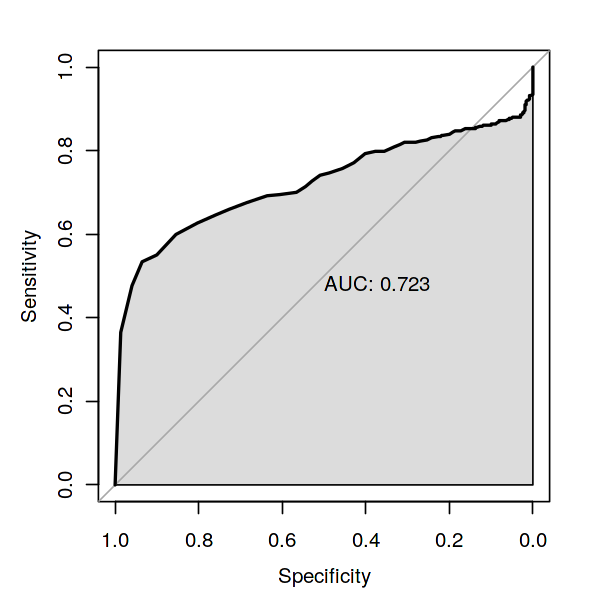

In [17]:
probs <- apply((predict(rf_model, train_df, type="prob")), 1, max)
roc(train_df$Class, probs, plot=TRUE, print.auc=TRUE, auc.polygon=TRUE)

### XGBoost Model

In [18]:
xgb_train <- xgb.DMatrix(data=as.matrix(train_df[,-31]), label=as.matrix(train_df[,31]))
xgb_test <- xgb.DMatrix(data=as.matrix(test_df[,-31]), label=as.matrix(test_df[,31]))

In [19]:
xgb_model <- xgboost(data=xgb_train,
                     max.depth=3, 
                     nround=500, 
                     early_stopping_rounds=10, 
                     objective="binary:logistic", 
                     verbose=0)

[1] "xgboost test accuracy: 94.31 %"


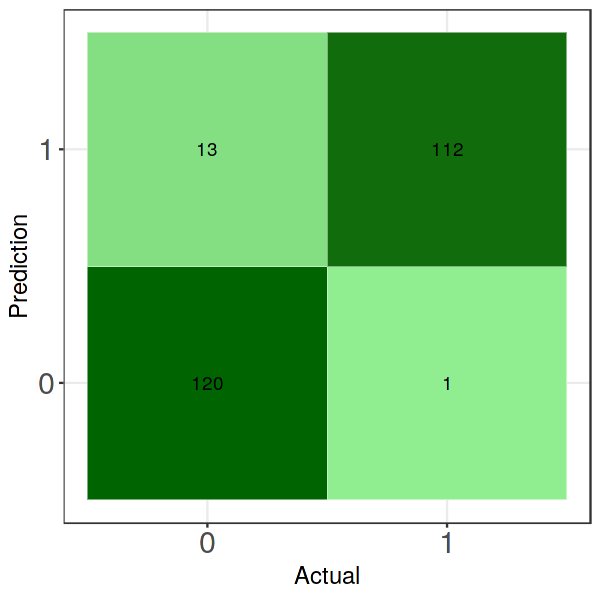

In [20]:
probs <- predict(xgb_model, xgb_test)
preds <- as.numeric(probs > 0.5)
plot_confusion_matrix(table(preds, test_df$Class))

acc <- round(mean(preds == test_df$Class), 4) * 100
print(paste("xgboost test accuracy:", acc, "%"))

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train_df$Class, predictor = probs, plot = TRUE,     print.auc = TRUE, auc.polygon = TRUE)

Data: probs in 371 controls (train_df$Class 0) < 367 cases (train_df$Class 1).
Area under the curve: 1

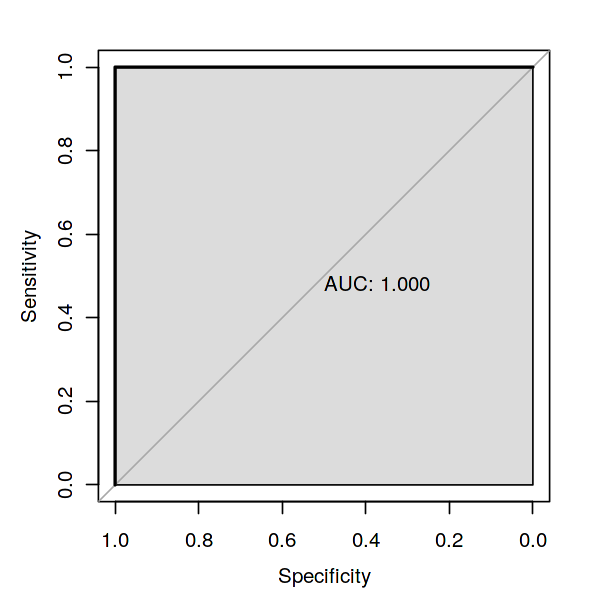

In [21]:
probs <- predict(xgb_model, xgb_train)
roc(train_df$Class, probs, plot=TRUE, print.auc=TRUE, auc.polygon=TRUE)

### LightGBM Model

In [22]:
lgb_train <- lgb.Dataset(as.matrix(train_df[,-31]), label=as.matrix(train_df[,31]))
lgb_test <- lgb.Dataset(as.matrix(test_df[,-31]), label=as.matrix(test_df[,31]))

In [23]:
lgb_model <- lgb.train(data=lgb_train, 
                       nrounds=500, 
                       max_depth=3, 
                       early_stopping_rounds=10, 
                       valids=list(test=lgb_test), 
                       objective="binary", 
                       verbose=0)

[1] "lightgbm test accuracy: 93.5 %"


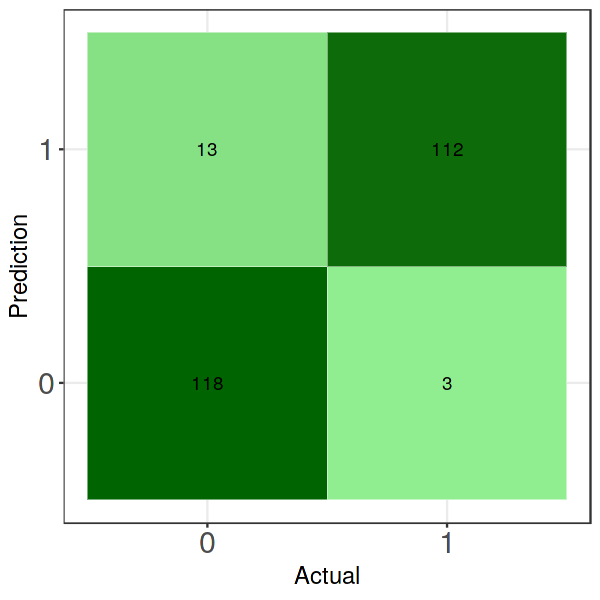

In [24]:
probs <- predict(lgb_model, as.matrix(test_df[,-31]))
preds <- as.numeric(probs > 0.5)
plot_confusion_matrix(table(preds, test_df$Class))

acc <- round(mean(preds == test_df$Class), 4) * 100
print(paste("lightgbm test accuracy:", acc, "%"))

Setting levels: control = 0, case = 1

Setting direction: controls < cases




Call:
roc.default(response = train_df$Class, predictor = probs, plot = TRUE,     print.auc = TRUE, auc.polygon = TRUE)

Data: probs in 371 controls (train_df$Class 0) < 367 cases (train_df$Class 1).
Area under the curve: 0.9994

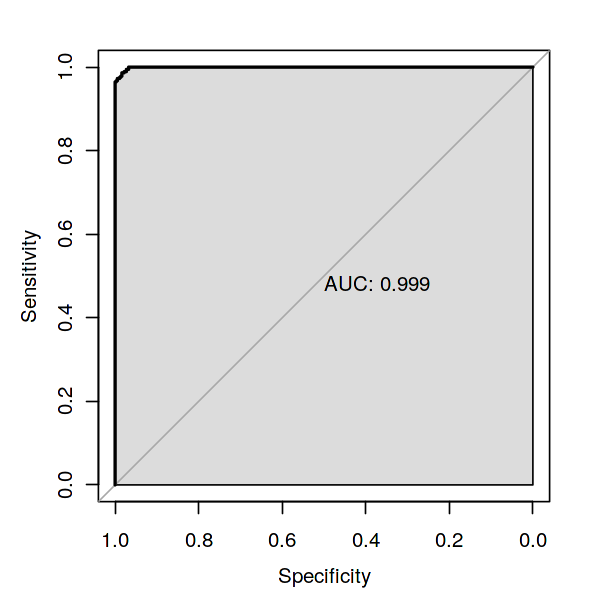

In [25]:
probs <- predict(lgb_model, as.matrix(train_df[,-31]))
roc(train_df$Class, probs, plot=TRUE, print.auc=TRUE, auc.polygon=TRUE)

## Conclusion
The best performing model was the XGBoost model with a test prediction accuracy of 94.31%, and AUC score of 1.00. The parameters for XGBoost could be experimented with further to see if we can increase the accuracy of the model even more.

Using a subsample of the dataset has given us more realistic accuracy scores for the models built. If I used the whole dataset, the accuracy for all the models would be deceivingly high due to the large imbalance of labels in the full dataset. Using the AUC score for a model's ROC is a far better indication of how well the model is performing when the dataset is very imbalanced. I included the AUC scores for all models here just to see how it compares to prediction accuracy.

A good example is for the random forest model, where the prediction accuracy is only around 1% lower than for Logistic Regression, yet it's AUC score is significantly lower. 